<a href="https://colab.research.google.com/github/Leoli04/llms-notebooks/blob/main/d2l/02_n2l_linear_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 线性神经网络

## 线性回归

在机器学习领域中的大多数任务通常都与预测（prediction）有关。 当我们想预测一个数值时，就会涉及到回归问题。 常见的例子包括：预测价格（房屋、股票等）、预测住院时间（针对住院病人等）、 预测需求（零售销量等）。但不是所有的预测都是回归问题，。分类问题的目标是预测数据属于一组类别中的哪一个。

### 线性回归的基本元素
线性回归基于几个简单的假设：
首先，假设自变量$\mathbf{x}$和因变量$y$之间的关系是线性的，
即$y$可以表示为$\mathbf{x}$中元素的加权和，这里通常允许包含观测值的一些噪声；
其次，我们假设任何噪声都比较正常，如噪声遵循正态分布。


为了解释*线性回归*，我们举一个实际的例子：
我们希望根据房屋的面积（平方英尺）和房龄（年）来估算房屋价格（美元）。
为了开发一个能预测房价的模型，我们需要收集一个真实的数据集。
这个数据集包括了房屋的销售价格、面积和房龄。
在机器学习的术语中，该数据集称为*训练数据集*（training data set）
或*训练集*（training set）。
每行数据（比如一次房屋交易相对应的数据）称为*样本*（sample），
也可以称为*数据点*（data point）或*数据样本*（data instance）。
我们把试图预测的目标（比如预测房屋价格）称为*标签*（label）或*目标*（target）。
预测所依据的自变量（面积和房龄）称为*特征*（feature）或*协变量*（covariate）。




#### 线性模型

线性假设是指目标（房屋价格）可以表示为特征（面积和房龄）的加权和，如下面的式子：

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$


 其中的$w_{\mathrm{area}}$和$w_{\mathrm{age}}$
称为*权重*（weight），权重决定了每个特征对我们预测值的影响。
$b$称为*偏置*（bias）、*偏移量*（offset）或*截距*（intercept）。


给定一个数据集，我们的目标是寻找模型的权重$\mathbf{w}$和偏置$b$，
使得根据模型做出的预测大体符合数据里的真实价格。

在开始寻找最好的*模型参数*（model parameters）$\mathbf{w}$和$b$之前，
我们还需要两个东西：
（1）一种模型质量的度量方式；
（2）一种能够更新模型以提高模型预测质量的方法。

#### 损失函数
*损失函数*（loss function）能够量化目标的*实际*值与*预测*值之间的差距。
通常我们会选择非负数作为损失，且数值越小表示损失越小，完美预测时的损失为0。
回归问题中最常用的损失函数是平方误差函数。

#### 随机梯度下降

梯度下降（gradient descent）的方法几乎可以优化所有深度学习模型。 它通过不断地在损失函数递减的方向上更新参数来降低误差。

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值） 关于模型参数的导数（在这里也可以称为梯度）。由于数据通常会比较大，我们通常会在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。

#### 用模型预测
给定特征估计目标的过程通常称为预测（prediction）或推断（inference）。


### 矢量化加速

矢量化代码通常会带来数量级的加速。

###  小结
- 机器学习模型中的关键要素是训练数据、损失函数、优化算法，还有模型本身。

- 矢量化使数学表达上更简洁，同时运行的更快。

- 最小化目标函数和执行极大似然估计等价。

- 线性回归是对n维输入的加权，外加偏差
- 使用平方损失来衡量预测值和真实值的差异
- 线性回归有显示解

- 线性回归模型也是一个简单的神经网络。

- 梯度下降通过不断沿着反梯度方向更新参数求解

- 小批量随机梯度下降是深度学习默认的求解算法

- 两个重要的超参数是批量大小和学习率

## 线性回归的从零开始实现

我们将从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [ ]:
!pip install d2l

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。

In [3]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    # 生成了一个形状为(num_examples, len(w))的二维张量.
    # 其中num_examples是样本数量，len(w)是特征的数量。矩阵中的每个元素都服从均值为0、标准差为1的正态分布。
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.9354, -1.6337]) 
label: tensor([5.8857])


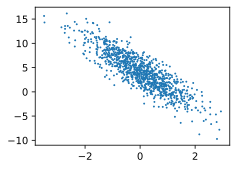

In [5]:
# 通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);


### 读取数据

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2168, -1.1313],
        [-2.7601,  0.5014],
        [ 0.7357, -1.2053],
        [-1.6621, -2.0656],
        [ 0.4257,  0.0135],
        [ 0.1364, -0.1575],
        [ 0.9994, -1.5098],
        [ 0.0817,  0.1178],
        [-0.3781, -0.0412],
        [ 0.4370, -0.3401]]) 
 tensor([[ 8.4906],
        [-3.0326],
        [ 9.7546],
        [ 7.8999],
        [ 4.9905],
        [ 5.0122],
        [11.3339],
        [ 3.9565],
        [ 3.5809],
        [ 6.2323]])


### 初始化模型参数



In [9]:
# 通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

定义线性函数

In [10]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。

损失函数是量化目标的实际值与预测值之间的差距。这里使用平方损失函数

In [11]:
def squared_loss(y_hat, y):
    """均方损失"""
    # 预测值y_hat
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。

In [12]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            # 除以batch_size是为了从批量梯度得到平均梯度
            param -= lr * param.grad / batch_size
            # 更新参数后，将当前参数的梯度清零
            param.grad.zero_()

### 训练

In [13]:
# 学习率
lr = 0.03
# 迭代周期个数
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041399
epoch 2, loss 0.000156
epoch 3, loss 0.000052


In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 8.0097e-04, -6.4135e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


##  线性回归的简洁实现

通过现有框架实现。

In [15]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# 生成数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# 读取数据
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [19]:

# nn是神经网络的缩写
from torch import nn

# # 定义模型

# Sequential类将多个层串联在一起。当给定输入数据时，Sequential实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，以此类推。
# nn.Linear(2, 1)将一个长度为2的向量转换为一个长度为1的向量
net = nn.Sequential(nn.Linear(2, 1))

# 初始化模型参数
# 每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样， 偏置参数将初始化为零
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
print("权重：", net[0].weight)
print("偏置：", net[0].bias)

# 定义损失函数
loss = nn.MSELoss()

# 定义优化算法
# 小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种.
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

权重： Parameter containing:
tensor([[0.0065, 0.0111]], requires_grad=True)
偏置： Parameter containing:
tensor([0.], requires_grad=True)


In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000262
epoch 2, loss 0.000099
epoch 3, loss 0.000099


In [18]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 1.7881e-06, -5.3692e-04])
b的估计误差： tensor([0.0002])


## softmax回归

- 回归估计一个连续值，分类预测一个离散类别
- Softmax 回归是一个多类分类模型
- softmax运算获取一个向量并将其映射为概率。
- softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布。
- 交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数。



## 图像分类数据集

我们将使用Fashion-MNIST数据集。
Fashion-MNIST由10个类别的图像组成， 每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。

### 读取数据

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

# 读取数据

# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [23]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [29]:
# print(mnist_train)
mnist_train[0][0].shape

torch.Size([1, 28, 28])

每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1。

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）

In [30]:
# 定义函数用于在数字标签索引及其文本名称之间进行转换
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [32]:
# 创建一个函数来可视化这些样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

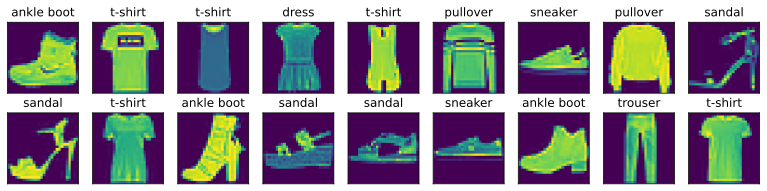

In [33]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### 读取小批量

In [34]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
# 读取一批训练集数据消耗时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'9.41 sec'

### 整合所有组件

In [36]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [37]:
# 指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## softmax回归的从零开始实现

使用刚刚在上一节中引入的Fashion-MNIST数据集， 并设置数据迭代器的批量大小为256。

### 加载数据

In [38]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型参数

和之前线性回归的例子一样，这里的每个样本都将用固定长度的向量表示。 原始数据集中的每个样本都是$28 \times 28$
的图像。 本节将展平每个图像，把它们看作长度为784的向量。


在softmax回归中，我们的输出与类别一样多。
(**因为我们的数据集有10个类别，所以网络输出维度为10**)。
因此，权重将构成一个$784 \times 10$的矩阵，
偏置将构成一个$1 \times 10$的行向量。

In [39]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [40]:
torch.normal?

### 定义softmax操作

[**实现softmax**]由三个步骤组成：

1. 对每个项求幂（使用`exp`）；
1. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
1. 将每一行除以其规范化常数，确保结果的和为1。

对应这个表达式：

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$


分母或规范化常数，有时也称为*配分函数*（其对数称为对数-配分函数）。

In [42]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [43]:
# 测试softmax
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1976, 0.2511, 0.1740, 0.1186, 0.2587],
         [0.0602, 0.1266, 0.2269, 0.4299, 0.1565]]),
 tensor([1., 1.]))

### 定义模型

定义softmax操作后，我们可以实现softmax回归模型。

In [44]:
def net(X):
  # X.reshape((-1, W.shape[0])) 将 X 重塑为一个形状为 (-1, num_inputs) 的张量，
  # -1 表示自动计算该维度的大小，使总元素数量保持不变。
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数

在机器学习和深度学习中，交叉熵损失函数通常用于分类任务。

交叉熵采用真实标签的预测概率的负对数似然。

In [45]:
# 标签y
y = torch.tensor([0, 2])
# 创建一个数据样本y_hat，其中包含2个样本在3个类别的预测概率
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 使用y作为y_hat中概率的索引， 我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [46]:
# 交叉熵损失函数的函数
def cross_entropy(y_hat, y):
    # range(len(y_hat)) 生成一个从 0 到 batch_size-1 的索引列表，用于选择 y_hat 中每行的元素。
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度

首先，如果y_hat是矩阵，那么假定第二个维度存储每个类的预测分数。 我们使用argmax获得每行中最大元素的索引来获得预测类别。 然后我们将预测类别与真实y元素进行比较。 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。

In [47]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [48]:
accuracy(y_hat, y) / len(y)

0.5

In [49]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [50]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

由于我们使用随机权重初始化net模型， 因此该模型的精度应接近于随机猜测0.1（有10个类别情况下的精度为0.1）。

In [51]:
evaluate_accuracy(net, test_iter)

0.0701

### 训练

In [52]:
# 定义一个函数来训练一个迭代周期。 请注意，updater是更新模型参数的常用函数，它接受批量大小作为参数。
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [53]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [54]:
# 训练函数， 它会在train_iter访问到的训练数据集上训练一个模型net。 该训练函数将会运行多个迭代周期（由num_epochs指定）。
# 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。 我们将利用Animator类来可视化训练进度。
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [55]:
# 定义的 小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

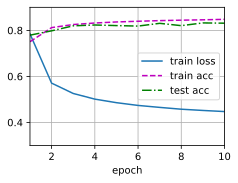

In [56]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

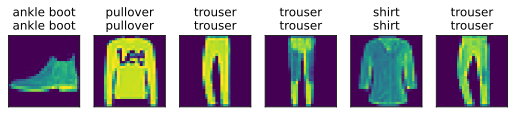

In [57]:
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## softmax回归的简洁实现

通过深度学习框架的高级API能够使实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数

# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

# 重新审视Softmax的实现

loss = nn.CrossEntropyLoss(reduction='none')

# 优化算法

# 使用学习率为0.1的小批量随机梯度下降作为优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# 训练
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)